## Improved Directory iterator ##

#### R. Barker, CAS_PML, 2019.01.21
- Required to improve transforms for BBox


In [4]:
from keras.preprocessing import image
from keras.preprocessing.image import DirectoryIterator, ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard
from keras import backend as K
import matplotlib.pyplot as plt
from PIL import Image as pil_image

Using TensorFlow backend.


In [ ]:
class DirectoryIteratorWithBoundingBoxes(DirectoryIterator):
    def __init__(self, directory, image_data_generator, bounding_boxes: dict = None, target_size=(256, 256),
                 color_mode: str = 'rgb', classes=None, class_mode: str = 'categorical', batch_size: int = 32,
                 shuffle: bool = True, seed=None, data_format=None, save_to_dir=None,
                 save_prefix: str = '', save_format: str = 'jpeg', follow_links: bool = False):
        super().__init__(directory, image_data_generator, target_size, color_mode, classes, class_mode, batch_size,
                         shuffle, seed, data_format, save_to_dir, save_prefix, save_format, follow_links)
        self.bounding_boxes = bounding_boxes

    def next(self):
        """
        # Returns
            The next batch.
        """
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=K.floatx())
        locations = np.zeros((len(batch_x),) + (4,), dtype=K.floatx())

        grayscale = self.color_mode == 'grayscale'

        # build batch of image data
        for i, j in enumerate(index_array):
            fname = self.filenames[j]
            img = image.load_img(os.path.join(self.directory, fname),
                                 grayscale=grayscale,
                                 target_size=self.target_size)
            x = image.img_to_array(img, data_format=self.data_format)
            x = self.image_data_generator.random_transform(x)
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x

            if self.bounding_boxes is not None:
                bounding_box = self.bounding_boxes[fname]
                locations[i] = np.asarray(
                    #[bounding_box['x1'], bounding_box['y1'], bounding_box['x2'], bounding_box['y2']],
                    bounding_box,
                    dtype=K.floatx())
        
        # optionally save augmented images to disk for debugging purposes
        if self.save_to_dir:
            for i, j in enumerate(index_array):
                #img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format( \
                          prefix=self.save_prefix, \
                          index=j, \
                          hash=np.random.randint(1e7), \
                          format=self.save_format)
                #img.save(os.path.join(self.save_to_dir, fname))
                img = np.asarray(batch_x[i], dtype=K.floatx())
                if img.shape[2] == 3:
                    imgo=pil_image.fromarray(img.astype('uint8'), 'RGB')
                else:
                    imgo=pil_image.fromarray(img[:, :, 0].astype('uint8'), 'L')
                    
                imgo.save(os.path.join(self.save_to_dir, fname))
        
        # build batch of labels
        if self.class_mode == 'sparse':
            batch_y = self.classes[index_array]
        elif self.class_mode == 'binary':
            batch_y = self.classes[index_array].astype(K.floatx())
        elif self.class_mode == 'categorical':
            batch_y = np.zeros((len(batch_x), 46), dtype=K.floatx())
            for i, label in enumerate(self.classes[index_array]):
                batch_y[i, label] = 1.
        else:
            return batch_x

        if self.bounding_boxes is not None:
            return batch_x, [batch_y, locations]
        else:
            return batch_x, batch_y

***
---


In [15]:
import json
import numpy as np
import os

In [7]:
# for directory defined class listings
with open('../data/Anno/list_bbox.txt', 'r') as bbox_file:
    list_bbox = [line.rstrip('\n') for line in bbox_file][2:]
    list_bbox = [line.split('/') for line in list_bbox]
    bb_dict= {l[1].split('_')[-1] + '/' + l[1] + '/' + l[2].split()[0]: \
              [int(xi) for xi in l[2].split()[-4:]] 
              for l in list_bbox}

In [ ]:
# for testing with as packed defined directory structure
with open('../data/Anno/list_bbox.txt', 'r') as bbox_file:
    list_bbox = [line.rstrip('\n') for line in bbox_file][2:]
    list_bbox = [line.split('/') for line in list_bbox]
    bb_dict= { l[1] + '/' + l[2].split()[0]: \
              [int(xi) for xi in l[2].split()[-4:]] \
              for l in list_bbox}

In [ ]:
bb_dict

In [ ]:
with open('../data/Anno/list_eval_partition.txt', 'r') as part_file:
    list_part = [line.rstrip('\n') for line in part_file][2:]
    list_part = [line.split('/') for line in list_part]
    part_dict = {l[1].split('_')[-1] + '/' + l[1] + '/' + l[2].split()[0]: \
                  l[2].split()[-1]
                  for l in list_part}

In [ ]:
train_dict = {k:v for k,v in bb_dict.items() if part_dict[k] == 'train'}
test_dict = {k:v for k,v in bb_dict.items() if part_dict[k] == 'test'}
val_dict = {k:v for k,v in bb_dict.items() if part_dict[k] == 'val'}

---

In [ ]:
train_dict

In [ ]:
bb_dict

In [ ]:
#train_datagen = ImageDataGenerator(rotation_range=30.,
#                                   shear_range=0.2,
#                                   zoom_range=0.2,
#                                   width_shift_range=0.2,
#                                   height_shift_range=0.2,
#                                   horizontal_flip=True)
train_datagen = ImageDataGenerator()

In [ ]:
dataDir = '/Volumes/SanDiskSSD/BFH_backup/CAS_PML/Project/DeepFashion/data/train/'
dataDir = '../data/Img/'

In [ ]:
train_iterator = DirectoryIteratorWithBoundingBoxes( \
                    dataDir, \
                    train_datagen, bounding_boxes=bb_dict, target_size=(200, 200),save_to_dir='./augmentOutput')

In [ ]:
test_iter = next(train_iterator)

In [ ]:
bb_dict

In [ ]:
plt.imshow(test_iter[0][0]/255)

In [ ]:
test_iter[1][1][0]

---
## Implement BB changes and ImgAug
---

In [1]:
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug import parameters as iap
ia.seed(1)

In [2]:
import matplotlib.pyplot as plt
from matplotlib import patches

In [16]:
class DirectoryIteratorWithBoundingBoxes(DirectoryIterator):
    def __init__(self, directory, image_data_generator, bounding_boxes: dict = None, target_size=(256, 256),
                 color_mode: str = 'rgb', classes=None, class_mode: str = 'categorical', batch_size: int = 32,
                 shuffle: bool = True, seed=None, data_format=None, save_to_dir=None,
                 save_prefix: str = '', save_format: str = 'jpeg', follow_links: bool = False):
        super().__init__(directory, image_data_generator, target_size, color_mode, classes, class_mode, batch_size,
                         shuffle, seed, data_format, save_to_dir, save_prefix, save_format, follow_links)
        self.bounding_boxes = bounding_boxes
        """tg = self.image_data_generator
        self.seqaug = iaa.Sequential([
                            iaa.CropToFixedSize(width=self.target_size[0], height=self.target_size[1]),
                            iaa.PadToFixedSize(width=self.target_size[0], height=self.target_size[1]),
                            iaa.KeepSizeByResize(
                                iaa.Affine(
                                    scale =iap.Uniform(*tg.zoom_range),
                                    rotate=iap.Uniform(-tg.rotation_range, tg.rotation_range),
                                    translate_percent={"x": iap.Uniform(-tg.width_shift_range,
                                                                         tg.width_shift_range),
                                                       "y": iap.Uniform(-tg.height_shift_range,
                                                                         tg.height_shift_range)}, 
                                    shear = iap.Uniform(-tg.shear_range,tg.shear_range),
                                    mode='constant',
                                    cval = 255,
                                    fit_output=True
                                )
                            ),
                            iaa.Fliplr(0.5 if tg.horizontal_flip else 0.0)
                    ]).to_deterministic()
        """
        

    def next(self):
        """
        # Returns
            The next batch.
        """
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        tg = self.image_data_generator
        seqaug = iaa.Sequential([
                            iaa.CropToFixedSize(width=self.target_size[0], height=self.target_size[1]),
                            iaa.PadToFixedSize(width=self.target_size[0], height=self.target_size[1]),
                            iaa.KeepSizeByResize(
                                iaa.Affine(
                                    scale =iap.Uniform(*tg.zoom_range),
                                    rotate=iap.Uniform(-tg.rotation_range, tg.rotation_range),
                                    translate_percent={"x": iap.Uniform(-tg.width_shift_range,
                                                                         tg.width_shift_range),
                                                       "y": iap.Uniform(-tg.height_shift_range,
                                                                         tg.height_shift_range)}, 
                                    shear = iap.Uniform(-tg.shear_range,tg.shear_range),
                                    mode='constant',
                                    cval = 255,
                                    fit_output=True
                                )
                            ),
                            iaa.Fliplr(0.5 if tg.horizontal_flip else 0.0)
                    ]).to_deterministic()
        
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=K.floatx())
        locations = np.zeros((len(batch_x),) + (4,), dtype=K.floatx())

        grayscale = self.color_mode == 'grayscale'

        # build batch of image data
        for i, j in enumerate(index_array):
            fname = self.filenames[j]
            bba = self.bounding_boxes[fname]
            #img = image.load_img(os.path.join(self.directory, fname),
            #                     grayscale=grayscale,
            #                     target_size=self.target_size)
            img = image.load_img(os.path.join(self.directory,fname))
            x = image.img_to_array(img, data_format=self.data_format)
            bbs = ia.BoundingBoxesOnImage([ia.BoundingBox(x1=bba[0],
                                                          y1=bba[1],
                                                          x2=bba[2],
                                                          y2=bba[3])],shape=x.shape)
            x = ia.imresize_single_image(x,self.target_size)
            bbx = bbs.on(x)  # resize bounding box to image shape now
            h,w,_ = x.shape
            
            # apply transforms image and bbox
            x = seqaug.augment_images([x])[0]
            bbx = seqaug.augment_bounding_boxes([bbx])[0].bounding_boxes[0]
            
            #img = img.resize(self.target_size)
            #x = self.image_data_generator.random_transform(x)
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x

            if self.bounding_boxes is not None:
                #bounding_box = self.bounding_boxes[fname]
                locations[i] = np.asarray(
                    #[bounding_box['x1'], bounding_box['y1'], bounding_box['x2'], bounding_box['y2']],
                    [bbx.x1/w, bbx.y1/h, bbx.x2/w, bbx.y2/h],
                    dtype=K.floatx())
        
        # optionally save augmented images to disk for debugging purposes
        if self.save_to_dir:
            for i, j in enumerate(index_array):
                #img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format( \
                          prefix=self.save_prefix, \
                          index=j, \
                          hash=np.random.randint(1e7), \
                          format=self.save_format)
                #img.save(os.path.join(self.save_to_dir, fname))
                #print("should be saving here:",self.save_to_dir + '/' + fname)
                img = np.asarray(batch_x[i], dtype=K.floatx())
                if img.shape[2] == 3:
                    imgo=pil_image.fromarray(img.astype('uint8'), 'RGB')
                else:
                    imgo=pil_image.fromarray(img[:, :, 0].astype('uint8'), 'L')
                    
                imgo.save(os.path.join(self.save_to_dir, fname))
        
        # build batch of labels
        if self.class_mode == 'sparse':
            batch_y = self.classes[index_array]
        elif self.class_mode == 'binary':
            batch_y = self.classes[index_array].astype(K.floatx())
        elif self.class_mode == 'categorical':
            batch_y = np.zeros((len(batch_x), 46), dtype=K.floatx())
            for i, label in enumerate(self.classes[index_array]):
                batch_y[i, label] = 1.
        else:
            return batch_x

        if self.bounding_boxes is not None:
            return batch_x, [batch_y, locations]
        else:
            return batch_x, batch_y

In [19]:
img_dir = '/Volumes/SanDiskSSD/BFH_backup/CAS_PML/Project/DeepFashion/data/test/'
#img_dir = '../data/Img/'
bb_keys=list(bb_dict.keys())

In [20]:
img = image.load_img(os.path.join(img_dir,bb_keys[4]))

In [34]:
img_resize=img.resize((250,250))

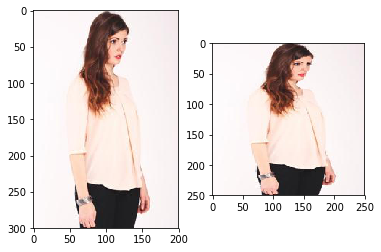

In [35]:
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(img)
ax2.imshow(img_resize)

In [36]:
img_arr = image.img_to_array(img)

In [25]:
img.size

(200, 300)

In [26]:
img_arr.shape

(300, 200, 3)

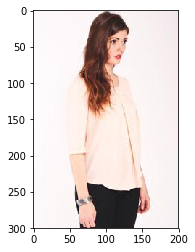

In [27]:
plt.imshow(img_arr/255.0)

---
---

In [21]:
train_datagen = ImageDataGenerator(rotation_range=10.,
                                   #shear_range=5.0,
                                   shear_range = 0,
                                   zoom_range=0,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

In [22]:
dataDir = '../data/Img/'
dataDir = '/Volumes/SanDiskSSD/BFH_backup/CAS_PML/Project/DeepFashion/data/test/'

In [23]:
train_iterator = DirectoryIteratorWithBoundingBoxes( \
                    dataDir, \
                    train_datagen, bounding_boxes=bb_dict, target_size=(200, 200),save_to_dir='./augmentOutput')

Found 40000 images belonging to 46 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_37055_5646055.jpeg
should be saving here: ./augmentOutput/_563_6725234.jpeg
should be saving here: ./augmentOutput/_6023_8569520.jpeg
should be saving here: ./augmentOutput/_30572_8160487.jpeg
should be saving here: ./augmentOutput/_2083_3149079.jpeg
should be saving here: ./augmentOutput/_36671_8862303.jpeg
should be saving here: ./augmentOutput/_251_1474852.jpeg
should be saving here: ./augmentOutput/_21669_3857957.jpeg
should be saving here: ./augmentOutput/_8501_9479061.jpeg
should be saving here: ./augmentOutput/_36448_3747875.jpeg
should be saving here: ./augmentOutput/_2967_3187236.jpeg
should be saving here: ./augmentOutput/_28487_773896.jpeg
should be saving here: ./augmentOutput/_28705_4498302.jpeg
should be saving here: ./augmentOutput/_21070_1731030.jpeg
should be saving here: ./augmentOutput/_31043_9283388.jpeg
should be saving here: ./augmentOutput/_19859_1622877.jpeg
should be saving here: ./augmentOutput/_22902_9589379.jpeg
should

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_22975_4062892.jpeg
should be saving here: ./augmentOutput/_18504_2541166.jpeg
should be saving here: ./augmentOutput/_2553_6078507.jpeg
should be saving here: ./augmentOutput/_26835_4485742.jpeg
should be saving here: ./augmentOutput/_1135_4291708.jpeg
should be saving here: ./augmentOutput/_19384_9834703.jpeg
should be saving here: ./augmentOutput/_28421_6000382.jpeg
should be saving here: ./augmentOutput/_38812_3088301.jpeg
should be saving here: ./augmentOutput/_37349_6516923.jpeg
should be saving here: ./augmentOutput/_14305_9676544.jpeg
should be saving here: ./augmentOutput/_22655_3802070.jpeg
should be saving here: ./augmentOutput/_14547_9784580.jpeg
should be saving here: ./augmentOutput/_8298_206165.jpeg
should be saving here: ./augmentOutput/_5233_350040.jpeg
should be saving here: ./augmentOutput/_18716_294437.jpeg
should be saving here: ./augmentOutput/_20865_8555996.jpeg
should be saving here: ./augmentOutput/_36975_4869071.jpeg
shou

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_37771_6437968.jpeg
should be saving here: ./augmentOutput/_27885_4546560.jpeg
should be saving here: ./augmentOutput/_4345_2006500.jpeg
should be saving here: ./augmentOutput/_29336_3517774.jpeg
should be saving here: ./augmentOutput/_19749_1596890.jpeg
should be saving here: ./augmentOutput/_31012_8893976.jpeg
should be saving here: ./augmentOutput/_13352_4804221.jpeg
should be saving here: ./augmentOutput/_18479_1345255.jpeg
should be saving here: ./augmentOutput/_15352_7213829.jpeg
should be saving here: ./augmentOutput/_27837_1005412.jpeg
should be saving here: ./augmentOutput/_16514_8365249.jpeg
should be saving here: ./augmentOutput/_30611_6272323.jpeg
should be saving here: ./augmentOutput/_30831_3162709.jpeg
should be saving here: ./augmentOutput/_8167_6723737.jpeg
should be saving here: ./augmentOutput/_17371_2284554.jpeg
should be saving here: ./augmentOutput/_2175_145198.jpeg
should be saving here: ./augmentOutput/_25028_53129.jpeg
sho

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_17037_2536753.jpeg
should be saving here: ./augmentOutput/_33379_3490173.jpeg
should be saving here: ./augmentOutput/_2073_5842491.jpeg
should be saving here: ./augmentOutput/_19402_8677895.jpeg
should be saving here: ./augmentOutput/_18497_1246214.jpeg
should be saving here: ./augmentOutput/_14602_1429260.jpeg
should be saving here: ./augmentOutput/_38147_9949062.jpeg
should be saving here: ./augmentOutput/_36218_7348191.jpeg
should be saving here: ./augmentOutput/_27977_4685749.jpeg
should be saving here: ./augmentOutput/_20697_1744951.jpeg
should be saving here: ./augmentOutput/_8362_2906276.jpeg
should be saving here: ./augmentOutput/_5300_7464925.jpeg
should be saving here: ./augmentOutput/_6985_2073772.jpeg
should be saving here: ./augmentOutput/_18373_6715041.jpeg
should be saving here: ./augmentOutput/_26519_9254069.jpeg
should be saving here: ./augmentOutput/_28608_8934840.jpeg
should be saving here: ./augmentOutput/_35748_7645120.jpeg
s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_9408_7494585.jpeg
should be saving here: ./augmentOutput/_13210_9425636.jpeg
should be saving here: ./augmentOutput/_30830_5129174.jpeg
should be saving here: ./augmentOutput/_29704_9052008.jpeg
should be saving here: ./augmentOutput/_6665_8218087.jpeg
should be saving here: ./augmentOutput/_16787_5888819.jpeg
should be saving here: ./augmentOutput/_36044_9248349.jpeg
should be saving here: ./augmentOutput/_3058_463266.jpeg
should be saving here: ./augmentOutput/_6601_3355581.jpeg
should be saving here: ./augmentOutput/_1945_1580775.jpeg
should be saving here: ./augmentOutput/_3528_8120289.jpeg
should be saving here: ./augmentOutput/_11112_7397526.jpeg
should be saving here: ./augmentOutput/_23853_6021667.jpeg
should be saving here: ./augmentOutput/_25643_7606822.jpeg
should be saving here: ./augmentOutput/_21096_2297442.jpeg
should be saving here: ./augmentOutput/_6031_4869866.jpeg
should be saving here: ./augmentOutput/_10696_4621240.jpeg
shoul

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_28312_6046025.jpeg
should be saving here: ./augmentOutput/_26582_3699906.jpeg
should be saving here: ./augmentOutput/_24771_1866845.jpeg
should be saving here: ./augmentOutput/_20754_2457432.jpeg
should be saving here: ./augmentOutput/_16067_4115983.jpeg
should be saving here: ./augmentOutput/_18720_484426.jpeg
should be saving here: ./augmentOutput/_2222_424236.jpeg
should be saving here: ./augmentOutput/_2814_1622087.jpeg
should be saving here: ./augmentOutput/_13715_1569592.jpeg
should be saving here: ./augmentOutput/_9589_5692716.jpeg
should be saving here: ./augmentOutput/_7825_9886910.jpeg
should be saving here: ./augmentOutput/_18627_8854804.jpeg
should be saving here: ./augmentOutput/_17260_7187461.jpeg
should be saving here: ./augmentOutput/_18987_2910076.jpeg
should be saving here: ./augmentOutput/_18452_5419252.jpeg
should be saving here: ./augmentOutput/_37491_8530163.jpeg
should be saving here: ./augmentOutput/_15617_5412097.jpeg
sho

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_28812_812082.jpeg
should be saving here: ./augmentOutput/_5732_5190432.jpeg
should be saving here: ./augmentOutput/_14471_4109669.jpeg
should be saving here: ./augmentOutput/_23755_1581494.jpeg
should be saving here: ./augmentOutput/_21138_5221411.jpeg
should be saving here: ./augmentOutput/_12651_5803004.jpeg
should be saving here: ./augmentOutput/_9076_5578641.jpeg
should be saving here: ./augmentOutput/_13449_8180501.jpeg
should be saving here: ./augmentOutput/_30819_642664.jpeg
should be saving here: ./augmentOutput/_24271_2680125.jpeg
should be saving here: ./augmentOutput/_38235_8664248.jpeg
should be saving here: ./augmentOutput/_19786_7517587.jpeg
should be saving here: ./augmentOutput/_16936_8942601.jpeg
should be saving here: ./augmentOutput/_14682_9178023.jpeg
should be saving here: ./augmentOutput/_25454_742514.jpeg
should be saving here: ./augmentOutput/_7543_3403594.jpeg
should be saving here: ./augmentOutput/_32609_9010468.jpeg
sho

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_36610_4802698.jpeg
should be saving here: ./augmentOutput/_19757_6208266.jpeg
should be saving here: ./augmentOutput/_8074_3991080.jpeg
should be saving here: ./augmentOutput/_7591_9814360.jpeg
should be saving here: ./augmentOutput/_31401_398529.jpeg
should be saving here: ./augmentOutput/_14284_3037863.jpeg
should be saving here: ./augmentOutput/_35204_8112687.jpeg
should be saving here: ./augmentOutput/_15975_3276372.jpeg
should be saving here: ./augmentOutput/_7562_9151142.jpeg
should be saving here: ./augmentOutput/_18938_3544321.jpeg
should be saving here: ./augmentOutput/_18002_7200396.jpeg
should be saving here: ./augmentOutput/_3449_2806372.jpeg
should be saving here: ./augmentOutput/_3838_9671372.jpeg
should be saving here: ./augmentOutput/_33448_6955276.jpeg
should be saving here: ./augmentOutput/_23961_3336480.jpeg
should be saving here: ./augmentOutput/_23333_5401202.jpeg
should be saving here: ./augmentOutput/_28196_1094368.jpeg
sho

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_33105_5501459.jpeg
should be saving here: ./augmentOutput/_13066_7453768.jpeg
should be saving here: ./augmentOutput/_38422_8907375.jpeg
should be saving here: ./augmentOutput/_27017_9032069.jpeg
should be saving here: ./augmentOutput/_3944_1999305.jpeg
should be saving here: ./augmentOutput/_20695_3987305.jpeg
should be saving here: ./augmentOutput/_7958_6118239.jpeg
should be saving here: ./augmentOutput/_17669_6943761.jpeg
should be saving here: ./augmentOutput/_32485_2779740.jpeg
should be saving here: ./augmentOutput/_23281_6175922.jpeg
should be saving here: ./augmentOutput/_29456_2830263.jpeg
should be saving here: ./augmentOutput/_23831_7460226.jpeg
should be saving here: ./augmentOutput/_27393_8276924.jpeg
should be saving here: ./augmentOutput/_31549_2904340.jpeg
should be saving here: ./augmentOutput/_24632_8728848.jpeg
should be saving here: ./augmentOutput/_16227_1555023.jpeg
should be saving here: ./augmentOutput/_29755_1942696.jpeg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_8834_5724461.jpeg
should be saving here: ./augmentOutput/_20041_475397.jpeg
should be saving here: ./augmentOutput/_26470_3708360.jpeg
should be saving here: ./augmentOutput/_5926_4930265.jpeg
should be saving here: ./augmentOutput/_28541_4005687.jpeg
should be saving here: ./augmentOutput/_758_2069184.jpeg
should be saving here: ./augmentOutput/_1030_8768237.jpeg
should be saving here: ./augmentOutput/_22228_3648352.jpeg
should be saving here: ./augmentOutput/_12973_7668787.jpeg
should be saving here: ./augmentOutput/_26260_8355672.jpeg
should be saving here: ./augmentOutput/_27218_1612388.jpeg
should be saving here: ./augmentOutput/_20440_915525.jpeg
should be saving here: ./augmentOutput/_11298_5262180.jpeg
should be saving here: ./augmentOutput/_20551_2158219.jpeg
should be saving here: ./augmentOutput/_14271_7687935.jpeg
should be saving here: ./augmentOutput/_38843_2431492.jpeg
should be saving here: ./augmentOutput/_29790_2650234.jpeg
shou

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_12694_4751055.jpeg
should be saving here: ./augmentOutput/_26763_6007109.jpeg
should be saving here: ./augmentOutput/_35369_8959834.jpeg
should be saving here: ./augmentOutput/_1653_5566455.jpeg
should be saving here: ./augmentOutput/_35755_8282942.jpeg
should be saving here: ./augmentOutput/_752_2154478.jpeg
should be saving here: ./augmentOutput/_36825_2675488.jpeg
should be saving here: ./augmentOutput/_32996_6602972.jpeg
should be saving here: ./augmentOutput/_11545_2849493.jpeg
should be saving here: ./augmentOutput/_5594_1478190.jpeg
should be saving here: ./augmentOutput/_31160_4867168.jpeg
should be saving here: ./augmentOutput/_6587_264275.jpeg
should be saving here: ./augmentOutput/_9495_3579968.jpeg
should be saving here: ./augmentOutput/_11324_6409545.jpeg
should be saving here: ./augmentOutput/_24610_2652248.jpeg
should be saving here: ./augmentOutput/_20239_3468287.jpeg
should be saving here: ./augmentOutput/_33034_1544745.jpeg
shou

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_7774_6490067.jpeg
should be saving here: ./augmentOutput/_16093_5482369.jpeg
should be saving here: ./augmentOutput/_9523_7126021.jpeg
should be saving here: ./augmentOutput/_1721_1440861.jpeg
should be saving here: ./augmentOutput/_21234_3361663.jpeg
should be saving here: ./augmentOutput/_30356_2003057.jpeg
should be saving here: ./augmentOutput/_1660_4764034.jpeg
should be saving here: ./augmentOutput/_29669_8415481.jpeg
should be saving here: ./augmentOutput/_32180_6869186.jpeg
should be saving here: ./augmentOutput/_30894_4410012.jpeg
should be saving here: ./augmentOutput/_22284_4045447.jpeg
should be saving here: ./augmentOutput/_2154_6410179.jpeg
should be saving here: ./augmentOutput/_8522_4880032.jpeg
should be saving here: ./augmentOutput/_1567_6972465.jpeg
should be saving here: ./augmentOutput/_39592_6947413.jpeg
should be saving here: ./augmentOutput/_4511_3213221.jpeg
should be saving here: ./augmentOutput/_5142_9123288.jpeg
should

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_39151_1122582.jpeg
should be saving here: ./augmentOutput/_7438_382663.jpeg
should be saving here: ./augmentOutput/_21752_7307241.jpeg
should be saving here: ./augmentOutput/_3253_6115958.jpeg
should be saving here: ./augmentOutput/_27794_1514271.jpeg
should be saving here: ./augmentOutput/_38986_6907348.jpeg
should be saving here: ./augmentOutput/_9279_9795632.jpeg
should be saving here: ./augmentOutput/_20927_7522928.jpeg
should be saving here: ./augmentOutput/_2333_4275381.jpeg
should be saving here: ./augmentOutput/_11483_1466246.jpeg
should be saving here: ./augmentOutput/_23191_505800.jpeg
should be saving here: ./augmentOutput/_21033_4138833.jpeg
should be saving here: ./augmentOutput/_11629_6475399.jpeg
should be saving here: ./augmentOutput/_13252_9341340.jpeg
should be saving here: ./augmentOutput/_31782_9445445.jpeg
should be saving here: ./augmentOutput/_21458_4151002.jpeg
should be saving here: ./augmentOutput/_6657_6819330.jpeg
shou

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_23637_4842813.jpeg
should be saving here: ./augmentOutput/_18843_369496.jpeg
should be saving here: ./augmentOutput/_16966_7197711.jpeg
should be saving here: ./augmentOutput/_10343_853791.jpeg
should be saving here: ./augmentOutput/_36021_3380123.jpeg
should be saving here: ./augmentOutput/_1093_7341025.jpeg
should be saving here: ./augmentOutput/_31115_9577858.jpeg
should be saving here: ./augmentOutput/_22768_4320655.jpeg
should be saving here: ./augmentOutput/_7414_2638401.jpeg
should be saving here: ./augmentOutput/_24690_2134867.jpeg
should be saving here: ./augmentOutput/_20701_9961580.jpeg
should be saving here: ./augmentOutput/_35652_3572540.jpeg
should be saving here: ./augmentOutput/_30224_5883935.jpeg
should be saving here: ./augmentOutput/_34746_1946610.jpeg
should be saving here: ./augmentOutput/_8090_9901720.jpeg
should be saving here: ./augmentOutput/_19202_2270985.jpeg
should be saving here: ./augmentOutput/_30520_252294.jpeg
sho

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_5066_6563382.jpeg
should be saving here: ./augmentOutput/_19466_214351.jpeg
should be saving here: ./augmentOutput/_26435_7467784.jpeg
should be saving here: ./augmentOutput/_20324_5314744.jpeg
should be saving here: ./augmentOutput/_18165_9871695.jpeg
should be saving here: ./augmentOutput/_22678_8199741.jpeg
should be saving here: ./augmentOutput/_7953_4087596.jpeg
should be saving here: ./augmentOutput/_39050_2324873.jpeg
should be saving here: ./augmentOutput/_7608_995952.jpeg
should be saving here: ./augmentOutput/_33912_379974.jpeg
should be saving here: ./augmentOutput/_372_7093485.jpeg
should be saving here: ./augmentOutput/_25383_8129486.jpeg
should be saving here: ./augmentOutput/_19207_5335687.jpeg
should be saving here: ./augmentOutput/_3375_1125149.jpeg
should be saving here: ./augmentOutput/_23928_2477625.jpeg
should be saving here: ./augmentOutput/_36217_77786.jpeg
should be saving here: ./augmentOutput/_34979_6374358.jpeg
should b

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_31533_2079341.jpeg
should be saving here: ./augmentOutput/_10672_673258.jpeg
should be saving here: ./augmentOutput/_33454_9143889.jpeg
should be saving here: ./augmentOutput/_13962_9821919.jpeg
should be saving here: ./augmentOutput/_27717_4796017.jpeg
should be saving here: ./augmentOutput/_17658_6964653.jpeg
should be saving here: ./augmentOutput/_8156_4424841.jpeg
should be saving here: ./augmentOutput/_25458_2528117.jpeg
should be saving here: ./augmentOutput/_4166_1044375.jpeg
should be saving here: ./augmentOutput/_6944_8834279.jpeg
should be saving here: ./augmentOutput/_39650_8880254.jpeg
should be saving here: ./augmentOutput/_6388_7167074.jpeg
should be saving here: ./augmentOutput/_17123_3217507.jpeg
should be saving here: ./augmentOutput/_39427_9804039.jpeg
should be saving here: ./augmentOutput/_646_7996979.jpeg
should be saving here: ./augmentOutput/_21441_9312147.jpeg
should be saving here: ./augmentOutput/_33584_5444359.jpeg
shou

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_35480_8510115.jpeg
should be saving here: ./augmentOutput/_32505_7738909.jpeg
should be saving here: ./augmentOutput/_37460_5161019.jpeg
should be saving here: ./augmentOutput/_5250_5360432.jpeg
should be saving here: ./augmentOutput/_14770_3362874.jpeg
should be saving here: ./augmentOutput/_35274_947100.jpeg
should be saving here: ./augmentOutput/_37837_7654925.jpeg
should be saving here: ./augmentOutput/_32843_9531778.jpeg
should be saving here: ./augmentOutput/_35206_7011775.jpeg
should be saving here: ./augmentOutput/_36001_9183188.jpeg
should be saving here: ./augmentOutput/_12534_5445203.jpeg
should be saving here: ./augmentOutput/_1210_2845533.jpeg
should be saving here: ./augmentOutput/_25845_7806617.jpeg
should be saving here: ./augmentOutput/_2497_3152846.jpeg
should be saving here: ./augmentOutput/_25968_8757350.jpeg
should be saving here: ./augmentOutput/_23186_861557.jpeg
should be saving here: ./augmentOutput/_6557_1788627.jpeg
sho

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_28761_6082727.jpeg
should be saving here: ./augmentOutput/_4824_1918403.jpeg
should be saving here: ./augmentOutput/_25960_8930270.jpeg
should be saving here: ./augmentOutput/_7831_633667.jpeg
should be saving here: ./augmentOutput/_25016_7489683.jpeg
should be saving here: ./augmentOutput/_8289_9310114.jpeg
should be saving here: ./augmentOutput/_26801_7748288.jpeg
should be saving here: ./augmentOutput/_38247_364885.jpeg
should be saving here: ./augmentOutput/_8390_2032992.jpeg
should be saving here: ./augmentOutput/_2522_7742891.jpeg
should be saving here: ./augmentOutput/_38107_6165809.jpeg
should be saving here: ./augmentOutput/_11389_8413564.jpeg
should be saving here: ./augmentOutput/_26687_1415497.jpeg
should be saving here: ./augmentOutput/_16851_6759563.jpeg
should be saving here: ./augmentOutput/_7278_5172259.jpeg
should be saving here: ./augmentOutput/_39842_7921645.jpeg
should be saving here: ./augmentOutput/_8191_3566813.jpeg
should

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_14122_1529186.jpeg
should be saving here: ./augmentOutput/_29157_3706241.jpeg
should be saving here: ./augmentOutput/_4753_1861381.jpeg
should be saving here: ./augmentOutput/_39610_3574924.jpeg
should be saving here: ./augmentOutput/_4261_4207382.jpeg
should be saving here: ./augmentOutput/_35914_9747061.jpeg
should be saving here: ./augmentOutput/_22289_9655547.jpeg
should be saving here: ./augmentOutput/_33628_5815734.jpeg
should be saving here: ./augmentOutput/_33708_1513536.jpeg
should be saving here: ./augmentOutput/_11713_1930273.jpeg
should be saving here: ./augmentOutput/_5615_3149938.jpeg
should be saving here: ./augmentOutput/_30613_8980441.jpeg
should be saving here: ./augmentOutput/_15198_7123412.jpeg
should be saving here: ./augmentOutput/_8563_9928304.jpeg
should be saving here: ./augmentOutput/_25687_3407230.jpeg
should be saving here: ./augmentOutput/_34699_4949686.jpeg
should be saving here: ./augmentOutput/_18397_7137961.jpeg
s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_38947_5994889.jpeg
should be saving here: ./augmentOutput/_4076_4565360.jpeg
should be saving here: ./augmentOutput/_24721_1676606.jpeg
should be saving here: ./augmentOutput/_21111_1608836.jpeg
should be saving here: ./augmentOutput/_12642_8132040.jpeg
should be saving here: ./augmentOutput/_29238_3846944.jpeg
should be saving here: ./augmentOutput/_32355_4319796.jpeg
should be saving here: ./augmentOutput/_29146_9752653.jpeg
should be saving here: ./augmentOutput/_15552_9970169.jpeg
should be saving here: ./augmentOutput/_16556_4783107.jpeg
should be saving here: ./augmentOutput/_33811_87589.jpeg
should be saving here: ./augmentOutput/_33915_8409502.jpeg
should be saving here: ./augmentOutput/_14801_6487847.jpeg
should be saving here: ./augmentOutput/_8449_6954458.jpeg
should be saving here: ./augmentOutput/_32814_7626592.jpeg
should be saving here: ./augmentOutput/_17995_86609.jpeg
should be saving here: ./augmentOutput/_14714_6899045.jpeg
sho

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_2983_7269831.jpeg
should be saving here: ./augmentOutput/_18282_3601604.jpeg
should be saving here: ./augmentOutput/_4537_556998.jpeg
should be saving here: ./augmentOutput/_13485_271639.jpeg
should be saving here: ./augmentOutput/_38261_1372151.jpeg
should be saving here: ./augmentOutput/_13465_6300267.jpeg
should be saving here: ./augmentOutput/_37001_4626437.jpeg
should be saving here: ./augmentOutput/_26629_9550060.jpeg
should be saving here: ./augmentOutput/_36944_2069165.jpeg
should be saving here: ./augmentOutput/_23287_5496661.jpeg
should be saving here: ./augmentOutput/_31827_5512054.jpeg
should be saving here: ./augmentOutput/_11116_3178444.jpeg
should be saving here: ./augmentOutput/_4095_9012530.jpeg
should be saving here: ./augmentOutput/_36586_1939180.jpeg
should be saving here: ./augmentOutput/_38656_608158.jpeg
should be saving here: ./augmentOutput/_1953_7500753.jpeg
should be saving here: ./augmentOutput/_18934_2111027.jpeg
shou

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_5709_9961914.jpeg
should be saving here: ./augmentOutput/_23926_2842147.jpeg
should be saving here: ./augmentOutput/_36252_3339209.jpeg
should be saving here: ./augmentOutput/_6096_8072678.jpeg
should be saving here: ./augmentOutput/_6370_4595391.jpeg
should be saving here: ./augmentOutput/_8822_6270469.jpeg
should be saving here: ./augmentOutput/_15649_404800.jpeg
should be saving here: ./augmentOutput/_36357_1631035.jpeg
should be saving here: ./augmentOutput/_35731_3448163.jpeg
should be saving here: ./augmentOutput/_13078_8972747.jpeg
should be saving here: ./augmentOutput/_15209_2251363.jpeg
should be saving here: ./augmentOutput/_10297_6431176.jpeg
should be saving here: ./augmentOutput/_38209_9689007.jpeg
should be saving here: ./augmentOutput/_34107_4060876.jpeg
should be saving here: ./augmentOutput/_24503_4454779.jpeg
should be saving here: ./augmentOutput/_23160_1594938.jpeg
should be saving here: ./augmentOutput/_31267_290905.jpeg
sho

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_5873_5724352.jpeg
should be saving here: ./augmentOutput/_8665_4199825.jpeg
should be saving here: ./augmentOutput/_19950_171837.jpeg
should be saving here: ./augmentOutput/_39729_2773683.jpeg
should be saving here: ./augmentOutput/_30759_6808494.jpeg
should be saving here: ./augmentOutput/_18547_754553.jpeg
should be saving here: ./augmentOutput/_18049_9514899.jpeg
should be saving here: ./augmentOutput/_1226_9144237.jpeg
should be saving here: ./augmentOutput/_20669_3944882.jpeg
should be saving here: ./augmentOutput/_38934_5851707.jpeg
should be saving here: ./augmentOutput/_33397_5982609.jpeg
should be saving here: ./augmentOutput/_34023_6409359.jpeg
should be saving here: ./augmentOutput/_21749_1118582.jpeg
should be saving here: ./augmentOutput/_11176_8068312.jpeg
should be saving here: ./augmentOutput/_1209_9699319.jpeg
should be saving here: ./augmentOutput/_9569_6400783.jpeg
should be saving here: ./augmentOutput/_39038_6207929.jpeg
shou

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_3212_2006660.jpeg
should be saving here: ./augmentOutput/_8223_9063480.jpeg
should be saving here: ./augmentOutput/_10553_5381077.jpeg
should be saving here: ./augmentOutput/_25714_253619.jpeg
should be saving here: ./augmentOutput/_8456_417452.jpeg
should be saving here: ./augmentOutput/_37585_7613656.jpeg
should be saving here: ./augmentOutput/_17558_6681584.jpeg
should be saving here: ./augmentOutput/_39469_7316265.jpeg
should be saving here: ./augmentOutput/_31578_5420214.jpeg
should be saving here: ./augmentOutput/_7687_3342838.jpeg
should be saving here: ./augmentOutput/_15217_4770149.jpeg
should be saving here: ./augmentOutput/_7281_2107057.jpeg
should be saving here: ./augmentOutput/_15002_2600296.jpeg
should be saving here: ./augmentOutput/_38368_8272577.jpeg
should be saving here: ./augmentOutput/_6029_2045539.jpeg
should be saving here: ./augmentOutput/_27857_754751.jpeg
should be saving here: ./augmentOutput/_9983_7577218.jpeg
should 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_15168_1604523.jpeg
should be saving here: ./augmentOutput/_28063_8046290.jpeg
should be saving here: ./augmentOutput/_37156_8684869.jpeg
should be saving here: ./augmentOutput/_12118_9055881.jpeg
should be saving here: ./augmentOutput/_35418_9337469.jpeg
should be saving here: ./augmentOutput/_28548_9501898.jpeg
should be saving here: ./augmentOutput/_19199_3180959.jpeg
should be saving here: ./augmentOutput/_13557_1548367.jpeg
should be saving here: ./augmentOutput/_17846_3642097.jpeg
should be saving here: ./augmentOutput/_10220_4273679.jpeg
should be saving here: ./augmentOutput/_31996_4525418.jpeg
should be saving here: ./augmentOutput/_3737_6624250.jpeg
should be saving here: ./augmentOutput/_13722_8401154.jpeg
should be saving here: ./augmentOutput/_37376_5410672.jpeg
should be saving here: ./augmentOutput/_14249_5477171.jpeg
should be saving here: ./augmentOutput/_13100_8826756.jpeg
should be saving here: ./augmentOutput/_1490_5389428.jpeg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_20393_4245804.jpeg
should be saving here: ./augmentOutput/_33634_2658351.jpeg
should be saving here: ./augmentOutput/_20614_4176393.jpeg
should be saving here: ./augmentOutput/_6860_9289347.jpeg
should be saving here: ./augmentOutput/_5079_9187646.jpeg
should be saving here: ./augmentOutput/_25944_8137988.jpeg
should be saving here: ./augmentOutput/_36936_9731758.jpeg
should be saving here: ./augmentOutput/_31174_2754105.jpeg
should be saving here: ./augmentOutput/_682_221291.jpeg
should be saving here: ./augmentOutput/_24779_2223845.jpeg
should be saving here: ./augmentOutput/_6660_254749.jpeg
should be saving here: ./augmentOutput/_34863_219539.jpeg
should be saving here: ./augmentOutput/_19857_8098785.jpeg
should be saving here: ./augmentOutput/_30586_2724755.jpeg
should be saving here: ./augmentOutput/_28690_5625939.jpeg
should be saving here: ./augmentOutput/_19630_9542367.jpeg
should be saving here: ./augmentOutput/_2047_5085405.jpeg
should

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_38613_1739482.jpeg
should be saving here: ./augmentOutput/_6393_3415718.jpeg
should be saving here: ./augmentOutput/_27626_6709784.jpeg
should be saving here: ./augmentOutput/_18834_1900970.jpeg
should be saving here: ./augmentOutput/_15731_8903253.jpeg
should be saving here: ./augmentOutput/_5378_4633039.jpeg
should be saving here: ./augmentOutput/_20473_1869242.jpeg
should be saving here: ./augmentOutput/_25099_3197115.jpeg
should be saving here: ./augmentOutput/_10755_5056213.jpeg
should be saving here: ./augmentOutput/_26247_9070478.jpeg
should be saving here: ./augmentOutput/_1927_1017191.jpeg
should be saving here: ./augmentOutput/_16494_3678398.jpeg
should be saving here: ./augmentOutput/_24315_6189492.jpeg
should be saving here: ./augmentOutput/_27588_6148501.jpeg
should be saving here: ./augmentOutput/_27481_9383612.jpeg
should be saving here: ./augmentOutput/_26169_3015362.jpeg
should be saving here: ./augmentOutput/_21626_5363171.jpeg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_3252_1234735.jpeg
should be saving here: ./augmentOutput/_17693_3992481.jpeg
should be saving here: ./augmentOutput/_18677_103724.jpeg
should be saving here: ./augmentOutput/_6092_3894844.jpeg
should be saving here: ./augmentOutput/_4501_7927959.jpeg
should be saving here: ./augmentOutput/_8718_6627508.jpeg
should be saving here: ./augmentOutput/_38008_7736276.jpeg
should be saving here: ./augmentOutput/_22872_8071099.jpeg
should be saving here: ./augmentOutput/_21561_6306809.jpeg
should be saving here: ./augmentOutput/_5546_8974215.jpeg
should be saving here: ./augmentOutput/_936_4574714.jpeg
should be saving here: ./augmentOutput/_6822_5361046.jpeg
should be saving here: ./augmentOutput/_19397_6908558.jpeg
should be saving here: ./augmentOutput/_38788_1526667.jpeg
should be saving here: ./augmentOutput/_21769_5380815.jpeg
should be saving here: ./augmentOutput/_35257_8198862.jpeg
should be saving here: ./augmentOutput/_26709_4853212.jpeg
should

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_5485_3585879.jpeg
should be saving here: ./augmentOutput/_30329_8745317.jpeg
should be saving here: ./augmentOutput/_29681_3428826.jpeg
should be saving here: ./augmentOutput/_36169_3567650.jpeg
should be saving here: ./augmentOutput/_30416_2460574.jpeg
should be saving here: ./augmentOutput/_35383_8120426.jpeg
should be saving here: ./augmentOutput/_34972_1649697.jpeg
should be saving here: ./augmentOutput/_29096_4967442.jpeg
should be saving here: ./augmentOutput/_13228_9374530.jpeg
should be saving here: ./augmentOutput/_39107_6525831.jpeg
should be saving here: ./augmentOutput/_9697_6085901.jpeg
should be saving here: ./augmentOutput/_11305_9087875.jpeg
should be saving here: ./augmentOutput/_702_8363421.jpeg
should be saving here: ./augmentOutput/_962_2920908.jpeg
should be saving here: ./augmentOutput/_6683_9528467.jpeg
should be saving here: ./augmentOutput/_19947_8924058.jpeg
should be saving here: ./augmentOutput/_17700_7096335.jpeg
shou

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_31700_3278885.jpeg
should be saving here: ./augmentOutput/_7936_136946.jpeg
should be saving here: ./augmentOutput/_12415_6452990.jpeg
should be saving here: ./augmentOutput/_8056_9621914.jpeg
should be saving here: ./augmentOutput/_33900_2705523.jpeg
should be saving here: ./augmentOutput/_14763_800536.jpeg
should be saving here: ./augmentOutput/_3854_1767930.jpeg
should be saving here: ./augmentOutput/_35168_4005507.jpeg
should be saving here: ./augmentOutput/_36755_9947759.jpeg
should be saving here: ./augmentOutput/_34618_5612296.jpeg
should be saving here: ./augmentOutput/_6812_9574166.jpeg
should be saving here: ./augmentOutput/_2712_5322075.jpeg
should be saving here: ./augmentOutput/_11169_7728322.jpeg
should be saving here: ./augmentOutput/_24526_1034991.jpeg
should be saving here: ./augmentOutput/_34975_77333.jpeg
should be saving here: ./augmentOutput/_4785_4919095.jpeg
should be saving here: ./augmentOutput/_22231_9944579.jpeg
should 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_17511_2370752.jpeg
should be saving here: ./augmentOutput/_1836_4236038.jpeg
should be saving here: ./augmentOutput/_10445_2409985.jpeg
should be saving here: ./augmentOutput/_36124_5331739.jpeg
should be saving here: ./augmentOutput/_12766_42323.jpeg
should be saving here: ./augmentOutput/_30125_563085.jpeg
should be saving here: ./augmentOutput/_16896_1423067.jpeg
should be saving here: ./augmentOutput/_18154_1298617.jpeg
should be saving here: ./augmentOutput/_23108_9136652.jpeg
should be saving here: ./augmentOutput/_4434_2821577.jpeg
should be saving here: ./augmentOutput/_34582_2068485.jpeg
should be saving here: ./augmentOutput/_36587_3866011.jpeg
should be saving here: ./augmentOutput/_25843_6953840.jpeg
should be saving here: ./augmentOutput/_24854_6427785.jpeg
should be saving here: ./augmentOutput/_34508_6966931.jpeg
should be saving here: ./augmentOutput/_37337_8277701.jpeg
should be saving here: ./augmentOutput/_16145_5579108.jpeg
sh

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_19122_200646.jpeg
should be saving here: ./augmentOutput/_13753_5627949.jpeg
should be saving here: ./augmentOutput/_19037_6162024.jpeg
should be saving here: ./augmentOutput/_5777_3000338.jpeg
should be saving here: ./augmentOutput/_21756_4144048.jpeg
should be saving here: ./augmentOutput/_8995_9959672.jpeg
should be saving here: ./augmentOutput/_8509_7097977.jpeg
should be saving here: ./augmentOutput/_916_3732611.jpeg
should be saving here: ./augmentOutput/_27036_2406615.jpeg
should be saving here: ./augmentOutput/_10597_3404498.jpeg
should be saving here: ./augmentOutput/_32691_440689.jpeg
should be saving here: ./augmentOutput/_8494_492650.jpeg
should be saving here: ./augmentOutput/_28155_7542374.jpeg
should be saving here: ./augmentOutput/_27148_2905133.jpeg
should be saving here: ./augmentOutput/_34625_1787855.jpeg
should be saving here: ./augmentOutput/_17538_9058033.jpeg
should be saving here: ./augmentOutput/_19973_1105857.jpeg
should

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should be saving here: ./augmentOutput/_16293_6301310.jpeg
should be saving here: ./augmentOutput/_35617_298406.jpeg
should be saving here: ./augmentOutput/_36431_8907863.jpeg
should be saving here: ./augmentOutput/_25966_3397572.jpeg
should be saving here: ./augmentOutput/_18116_9120409.jpeg
should be saving here: ./augmentOutput/_13001_288319.jpeg
should be saving here: ./augmentOutput/_4186_2132798.jpeg
should be saving here: ./augmentOutput/_2980_1163781.jpeg
should be saving here: ./augmentOutput/_1521_5446794.jpeg
should be saving here: ./augmentOutput/_20631_7966232.jpeg
should be saving here: ./augmentOutput/_3024_5727184.jpeg
should be saving here: ./augmentOutput/_25553_3465437.jpeg
should be saving here: ./augmentOutput/_33857_1804429.jpeg
should be saving here: ./augmentOutput/_28489_3624356.jpeg
should be saving here: ./augmentOutput/_9394_6751143.jpeg
should be saving here: ./augmentOutput/_33500_4942194.jpeg
should be saving here: ./augmentOutput/_29799_6474924.jpeg
shou

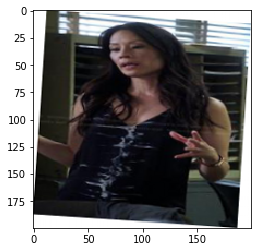

In [36]:
for i,img in enumerate(train_iterator):
    img_test = plt.imshow(img[0][0]/255.0)
    if i == 32: break

In [38]:
img = img_test[0][0]
w,h = img.shape[:2]
bb=list(img_test[1][1][0])
x1 = int(bb[0]*w) ; x2 = int(bb[2]* w)
y1 = int(bb[1]*h) ; y2 = int(bb[3]* h)

TypeError: 'AxesImage' object does not support indexing

In [37]:
rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor='r',facecolor='none')
fig,ax = plt.subplots(1)
ax.imshow(img/255)
ax.add_patch(rect)

NameError: name 'x1' is not defined

In [82]:
tg = train_iterator.image_data_generator
print("rotation=",tg.rotation_range)
print("shear=",tg.shear_range)
print("horizontal flip=",tg.horizontal_flip)
print("translate_x=",tg.width_shift_range)
print("translate_y=",tg.height_shift_range)
print("zoom range=",tg.zoom_range)

rotation= 10.0
shear= 0
horizontal flip= True
translate_x= 0.2
translate_y= 0.2
zoom range= [1, 1]


In [ ]:
from pathlib import Path

In [ ]:
os.getcwd()

In [41]:
train_iterator.classes.shape

(289219,)

In [87]:
len(train_iterator)

1250

In [100]:
%pwd

'/Users/rexbarker/BFH/CAS_PML/Project/DeepFashion/detect'

In [35]:
img[0].shape

(32, 200, 200, 3)